num_orb 4
Ham_K is ready!


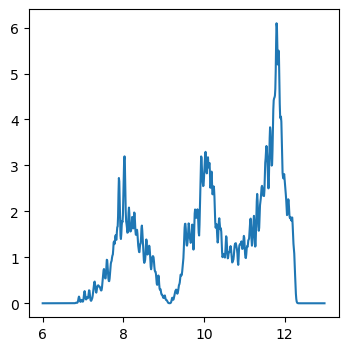

In [6]:
import numpy as np
import  math
import numba
from numba import jit




@jit(nopython=True) 
def dirac_delta(kT,E):
    if(math.fabs(E/kT) < 20):
        delta = (np.exp(E/kT)/kT)/(1 + np.exp(E/kT))**2
    else:
        delta = 0
    return delta


@jit(nopython=True) 
def kmesh_preparation(kmesh, cell_vec):
    
    num_kpoints = kmesh[0] * kmesh[1] * kmesh[2]
    rec_vec = np.zeros((3,3))
    k_vec  = np.zeros((num_kpoints,3))

    rec_vec[0]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[1], cell_vec[2])
    rec_vec[1]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[2], cell_vec[0])
    rec_vec[2]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[0], cell_vec[1])

    for q1 in range(kmesh[0]):
        for q2 in range(kmesh[1]):
            for q3 in range(kmesh[2]):
                q = (q1 * kmesh[1] * kmesh[2]) + (q2 * kmesh[2]) + q3
                k_vec[q] = (rec_vec[0] * q1/ kmesh[0]) + (rec_vec[1] * q2 / kmesh[1]) + (rec_vec[2] * q3 / kmesh[2])

    return k_vec 


@jit(nopython=True) 
def calc_hamK(num_orb, num_kpoints, n_min, n_max, cell_vec, k_vec, Ham_R):
    #Fourier transformation  of Hamiltonian
    Ham_K = np.zeros((num_kpoints, num_orb, num_orb), dtype=np.complex128)

    for i in range(n_min[0], n_max[0]):
        for j in range(n_min[1], n_max[1]):
            for k in range(n_min[2], n_max[2]+1):
                r = i * cell_vec[0] + j * cell_vec[1] + k * cell_vec[2]
                t = (k_vec @ r).reshape(num_kpoints, 1, 1)
                t = np.exp(-1j * t)
                rhs = np.ascontiguousarray(Ham_R[i + n_max[0], j + n_max[1], k + n_max[2],:,:])
                Ham_K += t * rhs
                
    Ham_K = (Ham_K +  np.transpose(Ham_K.conj(), (0, 2, 1)))/2 #avoid small numerical error 

    return Ham_K


@jit(nopython=True) 
def bare_coulomb_q(kmesh):
    num_kpoints = kmesh[0] * kmesh[1] * kmesh[2]
    weight = 1/num_kpoints
    
    Vq = np.zeros(num_kpoints, dtype=np.complex128)
    
    for q in range(num_kpoints):
        if q == 0:
            Vq[q] = 4 * np.pi * 14.3948/(4.9 * np.linalg.norm(k_vec[q])**2 + 1e-3)
        else:
            Vq[q] = 4 * np.pi * 14.3948/(4.9 * np.linalg.norm(k_vec[q])**2 )
            
    return Vq
               

                


@jit(nopython=True) 
def polarization_operator(num_orb, kmesh, Ham_K):
    
    def fermi(kT,E):
        N = 1/(np.exp(E/kT) + 1)
        return N
    
    num_kpoints = kmesh[0] * kmesh[1] * kmesh[2]
    weight = 1/num_kpoints
    
    rpa_pol = np.zeros(num_kpoints, dtype=np.complex128)
        
    #smearing in eV
    delta =  0.01
    kT = 0.01
 
    for q1 in range(kmesh[0]):
        for q2 in range(kmesh[1]):
            for q3 in range(kmesh[2]): #q
                q = (q1 * kmesh[1] * kmesh[2])  + (q2 * kmesh[2]) + q3
#                 print("RPA_qmesh progress:", q)
        
                for k1 in range(kmesh[0]):
                    for k2 in range(kmesh[1]):
                        for k3 in range(kmesh[2]): #k
                            k = (k1 * kmesh[1] * kmesh[2])  + (k2 * kmesh[2]) + k3  # k
                            w_k, v_k = np.linalg.eigh(Ham_K[k])
                            
                            kq1 = (q1 + k1)%kmesh[0] 
                            kq2 = (q2 + k2)%kmesh[1] 
                            kq3 = (q3 + k2)%kmesh[2] #k+q
                            
                            kq = (kq1 * kmesh[1] * kmesh[2]) + (kq2 * kmesh[2]) + kq3  #k+q 
                            w_kq, v_kq = np.linalg.eigh(Ham_K[kq])
                            
                            #rpa polarisation
                            for m in range(num_orb):
                                for n in range(num_orb):
                                    v_dots = np.dot(np.ascontiguousarray(v_k[n]), np.ascontiguousarray(v_kq[m]))  
                                    rpa_pol[q] += 2 * weight * (fermi(kT, w_k[n]) - fermi(kT, w_kq[m])) * np.abs(v_dots)**2 / (w_kq[m] - w_k[n] - 1j*delta)
                                                                              
    return rpa_pol

    
@jit(nopython=True) 
def average(num_kpoints, num_orb, Ham_K, scr_vq):
    U_av = 0.0
    dos_F = 0.0
    kT = 0.01
    
    for k in range(num_kpoints):
        w_k, v_k = np.linalg.eigh(Ham_K[k])
        for n in range(num_orb):
            dos_F += dirac_delta(kT, w_k[n])
            U_av += dirac_delta(kT, w_k[n]) * scr_vq[k]
            
    U_av = U_av/dos_F         
            
    return U_av
   
    
@jit(nopython=True)    
def dos(num_kpoints, num_orb, energy, Ham_K):
    dos_F = np.zeros(len(energy))
    kT = 0.01  
    
    for en in range(len(energy)):
        for k in range(num_kpoints):
            w_k, v_k = np.linalg.eigh(Ham_K[k])
            for n in range(num_orb):
                dos_F[en] += 2 * dirac_delta(kT, energy[en] - w_k[n])
                
        dos_F[en] = dos_F[en]/num_kpoints        
            
    return dos_F
    
    
    

if __name__ == '__main__':
    
    kmesh = np.array([20,20,20])
    num_kpoints = kmesh[0] * kmesh[1] * kmesh[2]

    e_fermi = 0 # eV

    cell_vec = np.array([[-1.742087135,   1.742087135,   3.467599447],
                        [1.742087135,  -1.742087135,   3.467599447], 
                        [1.742087135,   1.742087135,  -3.467599447]])

    k_vec = kmesh_preparation(kmesh, cell_vec)

    with open('tb_model.dat') as fp:
        rows = (line.split() for line in fp)
        data = [([int(u) for u in row[:3]], [int(u) for u in row[3:5]],
                 [float(u) for u in row[5:]]) for row in rows]

    # [N, 3] vectors, [N, 2] orbitals, [N, 2] hamiltonian
    vecs, orbs, ham_values = map(np.array, zip(*data))
    ham_values = ham_values.astype('f8').view('c16').ravel()  # View as complex [N]

    num_orb = max(orbs[:,0])
    print('num_orb', num_orb)
    n_min, n_max = vecs.min(0), vecs.max(0)  # [3]
    n_size = n_max - n_min + 1  # Plus 1 for 0th

    Ham_R = np.zeros((*n_size, num_orb, num_orb), dtype='c16')
    Ham_R[(*(vecs + n_max).T, *(orbs.T - 1))] = ham_values
            
  
    #here we control doping via the Fermi energy
    Ham_R[n_max[0], n_max[1], n_max[2]] = \
    Ham_R[n_max[0], n_max[1], n_max[2]] - (e_fermi * np.diag(np.ones(num_orb)))
    

    Ham_K = calc_hamK(num_orb, num_kpoints, n_min, n_max, cell_vec, k_vec, Ham_R)
    print("Ham_K is ready!")
    
# Test this if you are not sure about smearing and kmesh
    import matplotlib.pyplot as plt
    energy = np.arange(6-e_fermi, 13 - e_fermi, 0.01)
    dos_F = dos(num_kpoints, num_orb, energy, Ham_K)
    
    fig = plt.figure(figsize=(4,4)) 
    plt.plot(energy, dos_F)
    fig.savefig('dos.png', dpi=300, facecolor='w', transparent=False)    
    
#     rpa_pol =  polarization_operator(num_orb, kmesh, Ham_K)
#     print("RPA polarization is ready!")
    
    
#     bare_vq = bare_coulomb_q(kmesh)
#     print("bare Coulomb is ready")
    
#     scr_vq = bare_vq/(1 + bare_vq * rpa_pol) 
  
#     bare_vq_av = average(num_kpoints, num_orb, Ham_K, bare_vq.real)
#     scr_vq_av = average(num_kpoints, num_orb, Ham_K, scr_vq.real)
    
#     print('Fermi energy: ',e_fermi, 'Bare/Scr Coulomb: ', bare_vq_av,'/',scr_vq_av) 